# Naive Bayes - Trained on the Sentiment 140 data set
In this section we'll attempt to build a custom Naive Bayes model for text classification. Naive Bayes classifiers use conditional probabilities based on pre-tagged data, so we will use pre-tagged data containing about 1.6 million tweets tagged for negative (0) and positive (4) sentiment. Try training and running a multinomial Naive Bayes model from sklearn. To "vectorize" the text, we must first apply a TFIDF (term-frequency/inverse document frequency) transformation to model the text values as numeric values.

https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

In [44]:
import os
import pandas as pd
from comment_scraper import get_sql_table # local module
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from tabulate import tabulate
plt.style.use('seaborn-notebook')

# supress warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# slklearn imports
from sklearn.feature_extraction.text import HashingVectorizer # alternative to tf-idf vectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [2]:
DATA_DIR = 'C:\\Users\\keatu\\Regis_archive\\practicum2_data\\'
dbname = os.path.join(DATA_DIR, "Youtube_Data_msnbc.db")

In [3]:
s140df = pd.read_csv(os.path.join(DATA_DIR,"resources","s140_processed.csv"), encoding='latin-1')

In [25]:
text=s140df['text']
target=s140df['target']
train_text, test_text, train_label, test_label=train_test_split(text, target, random_state=50)

In [26]:

estimators=[('vectorizer', HashingVectorizer(ngram_range=(1,1)))]
pipeline = Pipeline(estimators)
train_text_proc = pipeline.fit_transform(train_text)


In [27]:
nb_model = BernoulliNB()
nb_model.fit(train_text_proc, train_label)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [36]:
predicted_vals = nb_model.predict(test_text_proc)

In [45]:
test_text_proc = pipeline.fit_transform(test_text)

test_score = nb_model.score(test_text_proc,test_label)
predicted_vals = nb_model.predict(test_text_proc)

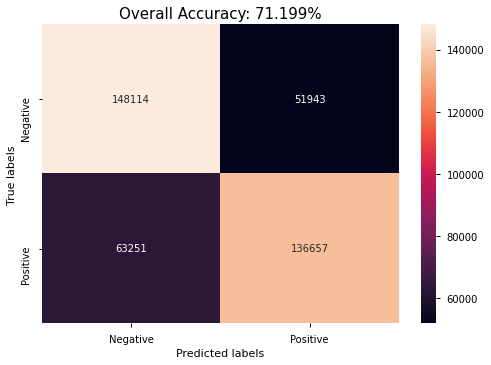

In [58]:
# Show overall accuracy and confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_label,predicted_vals), annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Overall Accuracy: {:.3f}%'.format(test_score*100.0), size=15); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

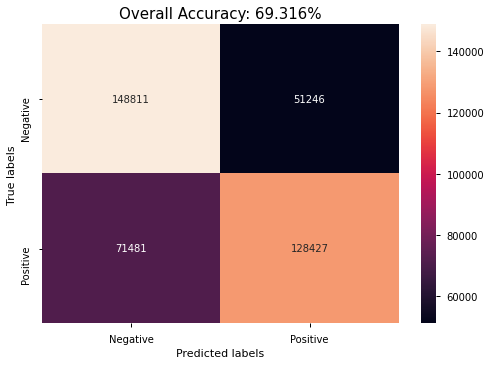

In [59]:
# See if pre-processing helps w/ score
s140df_trim = s140df.loc[~s140df['preproc_text'].isnull()] # pre-processed text was appended in script pre_proc.py
text=s140df_trim['preproc_text']
target=s140df_trim['target']
train_text, test_text, train_label, test_label=train_test_split(text, target, random_state=50)
estimators=[('vectorizer', HashingVectorizer(ngram_range=(1,1)))]
pipeline = Pipeline(estimators)
train_text_proc = pipeline.fit_transform(train_text)
nb_model = BernoulliNB()
nb_model.fit(train_text_proc, train_label)
test_text_proc = pipeline.fit_transform(test_text)
test_score = nb_model.score(test_text_proc,test_label)
predicted_vals = nb_model.predict(test_text_proc)
# Show overall accuracy and confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_label,predicted_vals), annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Overall Accuracy: {:.3f}%'.format(test_score*100.0), size=15); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

### Save model to disk

In [ ]:
filename = 'bernoullinb_model.sav'
with open(filename,'wb') as f:
    pickle.dump(mod, f)

# load it later
# with open(filename, 'rb') as f:
#    model = pickle.load(f)